# 0. 패키지 불러오기 

In [1]:
# 데이터 구성 패키지 : Series, DataFrame
import pandas as pd

# 행렬 연산 패키지 
import numpy as np

# matplotlib 불러오기 
import matplotlib
import matplotlib.pyplot as plt

# 날짜 데이터 생성 
from datetime import datetime

# 회귀 분석 
import statsmodels.api as sm

# 자기 상관 함수, 부분 자기상관 함수
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# ARIMA 
from statsmodels.tsa.arima_model import ARIMA

# 한글 깨짐 방지
import matplotlib.font_manager as fm 
font_list=[font.name for font in fm.fontManager.ttflist]
font_list
plt.rcParams['font.family']='NanumBarunGothic'

# 1. 데이터 구성하기 

In [2]:
# 파이명, 변수, 값 
df_raw=pd.read_csv("/home/piai/Downloads/3/환율.csv", engine='python', parse_dates=["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CURRENCY       273 non-null    object        
 1   APPL_DATE      273 non-null    datetime64[ns]
 2   STD_RATE       273 non-null    float64       
 3   USD_CONV_DATE  273 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 8.7+ KB


In [5]:
df_raw.describe()

,STD_RATE,USD_CONV_DATE
count,273.000000,273.000000
mean,808.240952,0.673413
std,447.946122,0.372926
min,176.960000,0.151600
25%,185.300000,0.153500
50%,1032.230000,0.878400
75%,1191.000000,1.000000
max,1239.000000,1.000000


In [8]:
df_raw_pivot=df_raw.pivot(index="APPL_DATE", columns="CURRENCY", values="STD_RATE")
df_raw_pivot.head()

CURRENCY,CNY,JPY,USD
APPL_DATE,,,
2016-01-01,181.48,976.99,1178.0
2016-01-02,181.48,976.99,1178.0
2016-01-03,181.48,976.99,1178.0
2016-01-04,181.10,992.62,1184.0
2016-01-05,181.94,993.00,1185.0


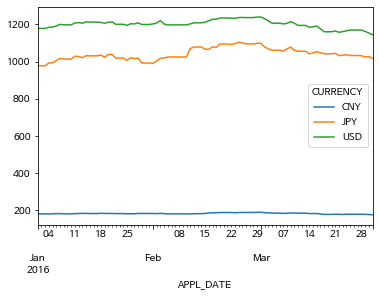

In [17]:
df_raw_pivot.plot()

# 2. 변동 추세 확인- 시간에 따른 환율 추세 그래프 생성  

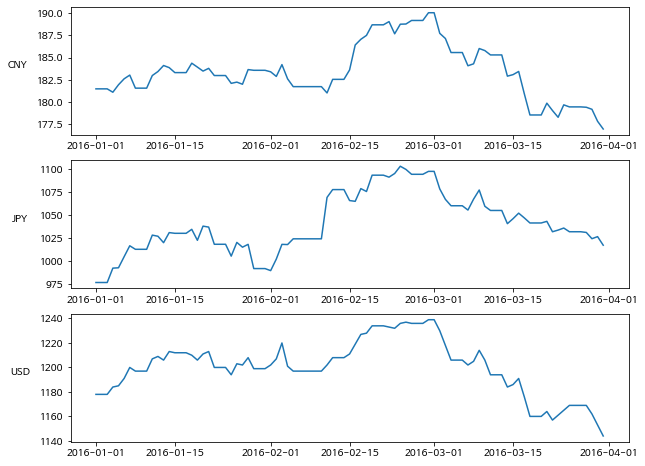

In [9]:
# 중국 위엔화와 엔화/달러 단위 크기가 다르기 때문에 각각 그래프를 새엇ㅇ -> 3행 1열, 크기 (10,8)
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3, ncols=1, figsize=(10,8))
# zip 햠수를 사용하면 zip함수 안의 리스트들을 하나씩 출력 

for (ax,idx,currency) in zip([ax1,ax2,ax3],[311,312,313],["CNY","JPY","USD"]):
    ax.plot("APPL_DATE","STD_RATE", data=df_raw[df_raw["CURRENCY"]==currency])
    ax.set_ylabel(currency,rotation=0, labelpad=20)
    
# 정상성을 확보하기 위해 차분이 필요하다. 

# 3. 시계열 분석 : 데이터 분할 - 통화별 데이터 분할 

In [10]:
# 데이터 분할 - 통화별 데이터 분할 
df_CNY=df_raw[df_raw["CURRENCY"]=='CNY'].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY","USD_CONV_DATE"],axis=1, inplace=True)

df_JPY=df_raw[df_raw["CURRENCY"]=='JPY'].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY","USD_CONV_DATE"],axis=1, inplace=True)

df_USD=df_raw[df_raw["CURRENCY"]=='USD'].set_index("APPL_DATE")
df_USD.drop(["CURRENCY","USD_CONV_DATE"],axis=1, inplace=True)

df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [13]:
# 데이터 분할 - train/test 데이터 분할 

# Train & Test 데이터 분할 : 비율 기준 mask 지정 : 답을 가리는 것 
train_size=0.9
len_idx=len(df_CNY.index)
mask=(np.arange(len_idx)/len_idx)<train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [14]:
# mask를 이용한 데이터 분할 
df_CNY_train=df_CNY[mask]
df_CNY_test=df_CNY[~mask]
print("shape of train data:{}".format(df_CNY_train.shape))
print("shape of test data:{}".format(df_CNY_test.shape))

shape of train data:(82, 1)
shape of test data:(9, 1)


In [15]:
# 추가 설명 : Train & Test 데이터 분할 : index 직접 지정 
df_CNY_train=df_CNY[df_CNY.index<="2016-03-22"]
df_CNY_test=df_CNY[df_CNY.index>"2016-03-22"]
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


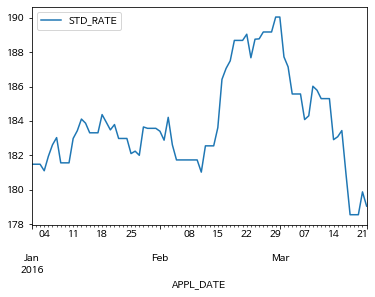

In [19]:
df_CNY_train.plot() # 차분 전 

### 시계열 분석 : 데이터 분할 - 차분을 통하여 정상성 데이터로 변환 

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


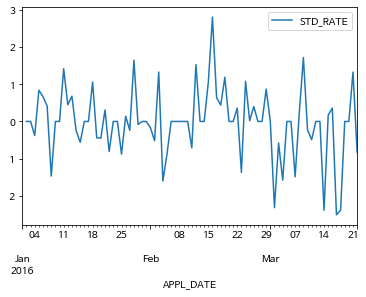

In [16]:
# 1차 차분 : z(t)-z(t-1)

# shift(n) : 앞의 n번째 행의 데이터를 가져옴 
df_CNY_diff1=df_CNY_train-df_CNY_train.shift(1)
df_CNY_diff1.plot()

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


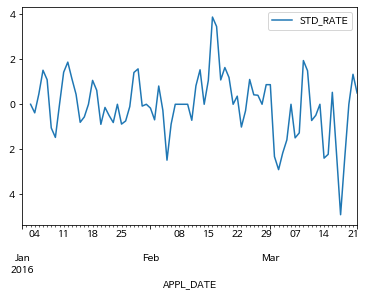

In [21]:
# 2차 차분 : (z(t)-z(t-1))-(z(t-1)-z(t-2))=z(t)-2*z(t-1)+z(t-2)

# shift(n) : 앞의 n번째 행의 데이터를 가져옴 
df_CNY_diff2=df_CNY_train-df_CNY_train.shift(2)
df_CNY_diff2.plot()

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


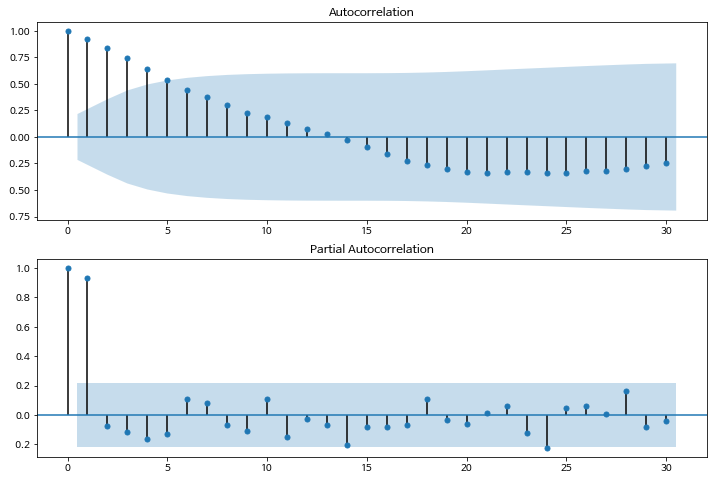

In [25]:
# 자기회귀 최대 p기간 지정
lag_size=30
fig=plt.figure(figsize=(12,8))

# acf 그래프를 그릴 공간 생성 
ax1=fig.add_subplot(211)

# 자기상관 함수 그래프 plot_acf 함수 사용
fig=plot_acf(df_CNY_train["STD_RATE"],lags=lag_size, ax=ax1) #["STD_RATE"] 생략 가능 

# pacf 그래프를 그릴 공간 생성 
ax2=fig.add_subplot(212)

#부분 자기상관 함수 그래프 plot_pacf 함수 사용
fig=plot_pacf(df_CNY_train["STD_RATE"],lags=lag_size, ax=ax2) #["STD_RATE"] 생략 가능 

### 시계열 분석 - 시계열 모델 - 자기상관 함수 및 부분 자기상관 함수

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


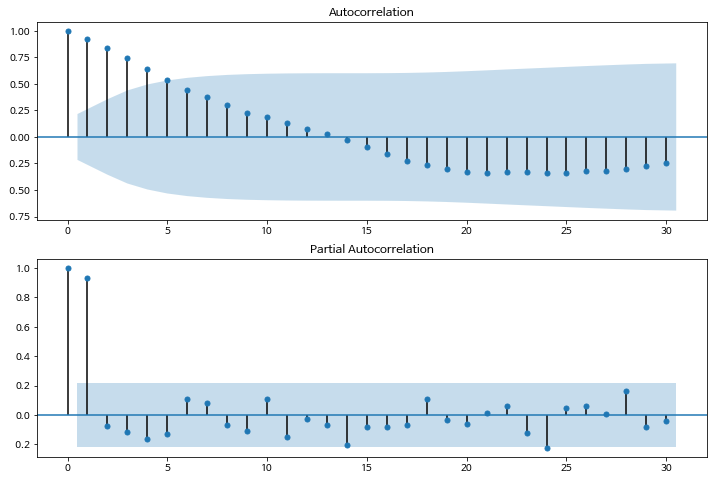

In [26]:
# Lag를 30까지 하여 ACF, PACF 산출
# 자기회귀 최대 p기간 지정
lag_size=30
fig=plt.figure(figsize=(12,8))

# acf그래프를 그릴 공간 생성
ax1=fig.add_subplot(211)

# 자기상관 함수 그래프 plot_acf 함수 사용
fig=plot_acf(df_CNY_train["STD_RATE"],lags=lag_size, ax=ax1)

# pacf 그래프를 그릴 공간 생성 
ax2=fig.add_subplot(212)

#부분 자기상관 함수 그래프 plot_pacf 함수 사용
fig=plot_pacf(df_CNY_train["STD_RATE"],lags=lag_size, ax=ax2)

In [27]:
# Train 데이터 이용 ,AR(1) I(2,차분), MA(0)인 ARIMA 모델
ts_model_cny=ARIMA(df_CNY_train,order=(1,2,0))

# 데이터 적합

# trend : 상수 포함 여부 'nc'이면 상수 미포함, full_output : 모든 출력 결과 표시
ts_result_cny=ts_model_cny.fit(trend="c", full_output=True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Wed, 18 Nov 2020   AIC                            253.025
Time:                        17:28:06   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/piai/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


# 4. 예측 및 결과 해석

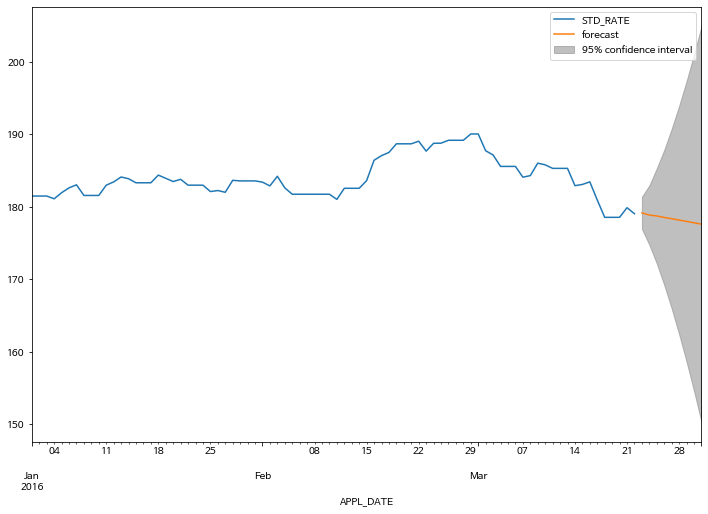

In [29]:
# 예측 시작/종료 날짜 지정
start_time=df_CNY_test.index.min()
end_time=df_CNY_test.index.max()
fig, ax=plt.subplots(figsize=(12,8))

# 예측 전까지 데이터
ax=df_CNY_train.plot(ax=ax)

# 예측 그래프 생성 함수, start:예측 시작, end:예측 종료, plot_insample: 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시 
fig=ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

In [31]:
# 전체 기간의 실제값, 예측값 확인
start_time=pd.to_datetime("2016-01-03") # 차분=2 -> 시작일자 + 2 이후부터 예측값 생성됨 
y_pred=ts_result_cny.predict(start=start_time, end=end_time, typ='levels')
df_merge=df_CNY # 실제값 저장 
df_merge["예측값"]=y_pred # 예측값 저장 및 변수명 지정 
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476898
2016-01-05,181.94,180.883667


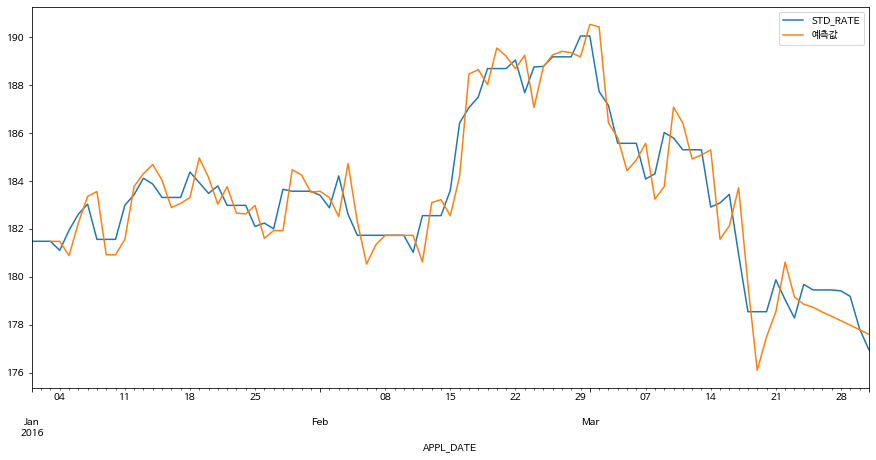

In [32]:
#추세 그래프 생성 및 확인
df_merge.plot(y=["STD_RATE","예측값"],figsize=(15,7))